<a href="https://colab.research.google.com/github/eunzzae/KaggleStudy_MustHave/blob/main/Chap09_%ED%96%A5%ED%9B%84_%ED%8C%90%EB%A7%A4%EB%9F%89_%EC%98%88%EC%B8%A1(EDA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 프로젝트 개요

## 1) 학습 목표  
성능 향상을 위한 파생 피처 만들기 위해 다양한 피처 엔지니어링 기법을 배울 수 있음
## 2) 학습 순서  
탐색적 데이터 분석 -> 베이스라인 모델 -> 성능개선
## 3) 학습 키워드  
* 유형 및 평가지표 : 회귀, RMSE
* 탐색적 데이터 분석 : 데이터 병합, 그룹화
* 머신러닝 모델 : lightGBM
* 피처 엔지니어링 : 피처명 한글화, 데이터 다운 캐스팅, 조합, 이어붙이기, 병합, 이상치 제거, 파생피처 생성


# 1. 경진대회 이해

* 훈련 데이터 관련된 추가 데이터 있음
  - sales_train : 2013년 1월부터 2015년 10월까지 일별 판매 내역
  - shops : 상점에 관한 추가 정보
  - items : 상품에 관한 추가 정보
  - item_categories : 상품 분류에 관한 추가 정보
  - test : 테스트 데이터(2015년 11월 각 상점의 상품별 월간 판매량을 예측해야 함)
  - sample_submission : 샘플 제출 파일

  ※ 주의사항 : 각 상점의 상품별 월간 판매량(타깃값)은 0개에서 20개 사이이어야 함 (20개 이상이거나 음수는 허용하지 않음)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# 데이터 경로
data_path = '/content/drive/MyDrive/[캐글] 스터디_musthave/data/competitive-data-science-predict-future-sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
sample_submission = pd.read_csv(data_path + 'sample_submission.csv')

## 1) 데이터 둘러보기

#### **sales_train 데이터**

In [4]:
sales_train.head()
# date_block_num 피처는 날짜(월) 구분자 2013년 1월은 0
# date 피처는 삭제
# shop_id, item_id는 상점id와 상품id
# item_cnt_day는 당일 판매량 -> 월간 판매량을 구해야 함

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
sales_train.info(show_counts=True) # 비결측값 개수 출력 파라미터(행이 1,690,785보다 많거나 열이 100개보다 많으면 비결측값 개수 출력X)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


#### **shops 데이터**

In [13]:
shops.head()
# 상점이름의 첫 단어는 도시
# shop_id를 기준으로 sales_train과 shops 병합

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


#### **items 데이터**

In [14]:
items.head()
# 상품명 피처제거
# item_id를 기준으로 sales_train과 items 병합

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


#### **item_categories 데이터**

In [12]:
item_categories.head()
# item_categories_id를 기준으로 sales_train과 items_categories 병합
# 상품 분류명에서 첫 단어는 대분류 -> 대분류 피처 생성

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [15]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


#### **test 데이터**

In [16]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


#### **데이터 병합**

In [29]:
train = sales_train.merge(shops, on='shop_id', how='left')
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


#### **피처 요약표 만들기**

* 상점ID, 상품ID, 상품분류ID는 각각 상점명, 상품명, 상품분류명과 1:1로 매칭되므로 둘 중 하나 제거해도 됨
* name 피처 중에 파생피처를 만들 수 있음

In [31]:
def resumetable(df):
  print(f'데이터셋 형상: {df.shape}')
  summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
  summary = summary.reset_index()
  summary = summary.rename(columns={'index':'피처'})
  summary['결측값 개수'] = df.isnull().sum().values
  summary['고윳값 개수'] = df.nunique().values
  summary['첫 번째 값'] = df.loc[0].values
  summary['두 번째 값'] = df.loc[1].values

  return summary
resumetable(train)

데이터셋 형상: (2935849, 10)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값
0,date,object,0,1034,02.01.2013,03.01.2013
1,date_block_num,int64,0,34,0,0
2,shop_id,int64,0,60,59,25
3,item_id,int64,0,21807,22154,2552
4,item_price,float64,0,19993,999.0,899.0
5,item_cnt_day,float64,0,198,1.0,1.0
6,shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""
7,item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP
8,item_category_id,int64,0,84,37,58
9,item_category_name,object,0,84,Кино - Blu-Ray,Музыка - Винил


## 2) 데이터 시각화


#### **일별 판매량**

In [33]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

* 이상치가 많음
* 일별 판매량에서 1000 이상 데이터(이상치) 제거

<Axes: ylabel='item_cnt_day'>

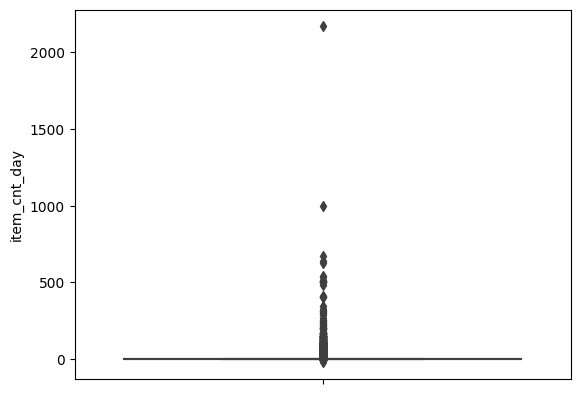

In [34]:
sns.boxplot(y='item_cnt_day', data=train)

#### **판매가(상품가격)**

* 판매가에서 50,000이상 데이터(이상치) 제거

<Axes: ylabel='item_price'>

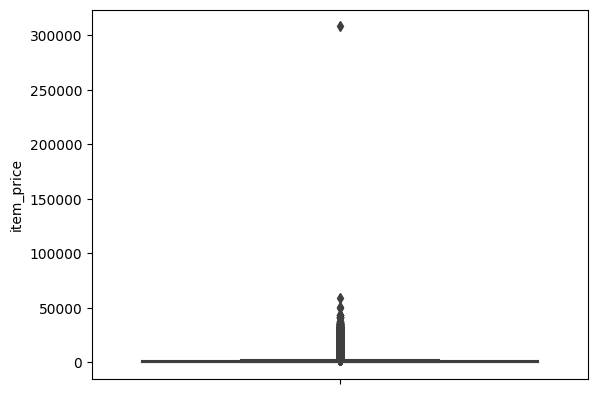

In [35]:
sns.boxplot(y='item_price', data=train)

#### **그룹화**

In [37]:
group = train.groupby('date_block_num').agg({'item_cnt_day':'sum'})
group.reset_index()

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


#### **월별 판매량**

[Text(0.5, 1.0, 'Distribution of monthly item counts by date block number'),
 Text(0.5, 0, 'Date block number'),
 Text(0, 0.5, 'Monthly item counts')]

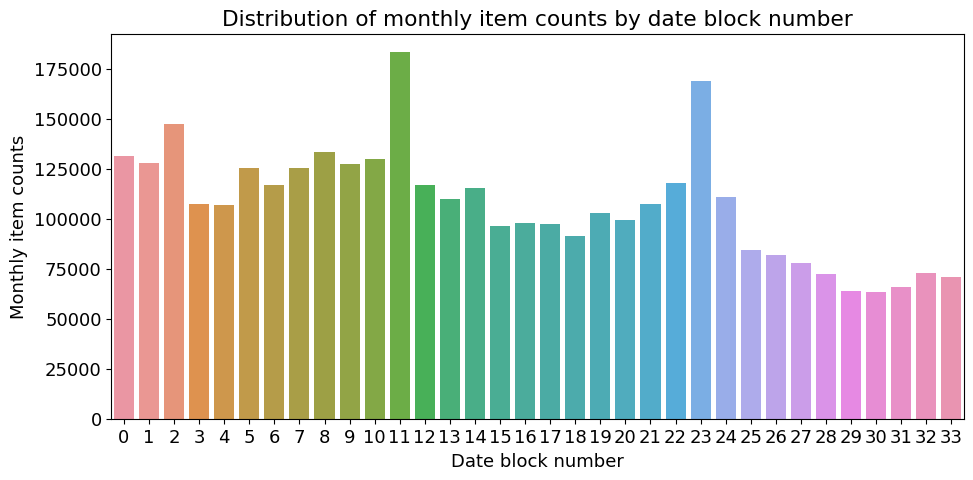

In [43]:
mpl.rc('font', size=13)
figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 월별 총 상품 판매량
group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day':'sum'})
group_month_sum = group_month_sum.reset_index()

# 월별 총 상품 판매량 막대 그래프
sns.barplot(data=group_month_sum, x='date_block_num', y='item_cnt_day')

# 그래프 제목, x축 라벨, y축 라벨명 설정
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number',
       ylabel='Monthly item counts')

#### **상품분류별 판매량**

In [45]:
train['item_category_id'].nunique()

84

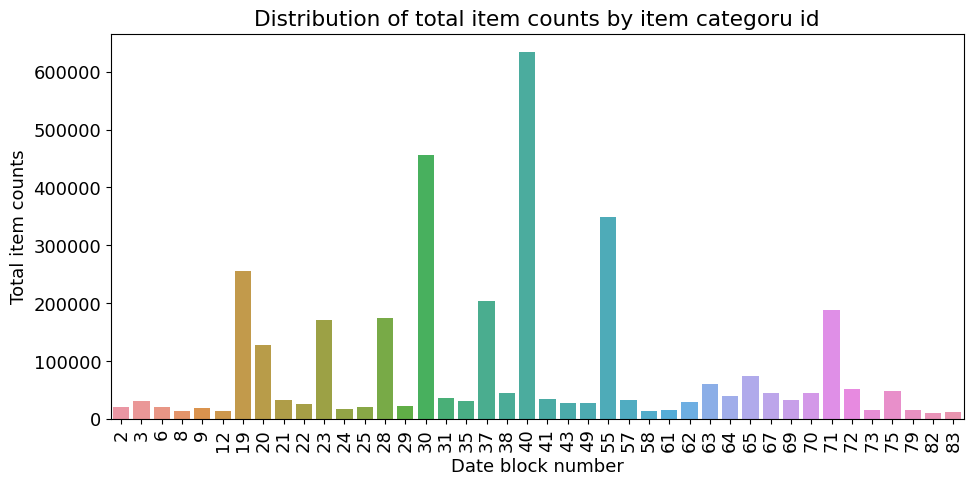

In [53]:
figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 상품분류별 총 상품 판매량
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day':'sum'})
group_cat_sum = group_cat_sum.reset_index()

# 월간 판매량이 10,000개를 초과하는 상품분류만 추출
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day']>10000]

# 상품분류별 총 상품 판매량 막대 그래프
sns.barplot(data=group_cat_sum, x='item_category_id', y='item_cnt_day')
ax.set(title='Distribution of total item counts by item categoru id',
       xlabel='Date block number',
       ylabel='Total item counts')

ax.tick_params(axis='x', labelrotation=90) # x축 라벨 회전

#### **상점별 판매량**

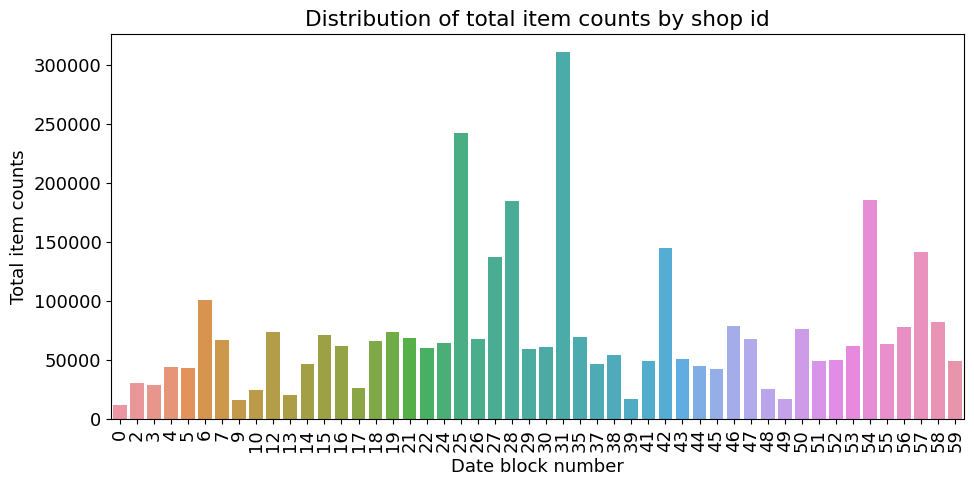

In [59]:
figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day':'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_day']>10000]

sns.barplot(data=group_shop_sum, x='shop_id', y='item_cnt_day')
ax.set(title='Distribution of total item counts by shop id',
       xlabel ='Date block number',
       ylabel ='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

# 분석정리 및 모델링 전략

## 분석정리
1. 대회의 타깃값 규정상 , 판매량 관련 피처 값은 모두 0~20 사이로 제한해야 함
2. 시계열 데이터 이므로 데이터 순서 꼭 지켜야 함
  * OOF 예측 등 데이터 순서가 무시되는 기법 사용 X
  * 거증 데이터는 훈련 데이터 중 가장 최근 1개월치 이용
3. 타깃값 : 월별 판매량을 예측해야 하나, 주어진 데이터에는 일별 판매량만 있으므로, 같은 달의 일별 판매량을 합쳐 타깃값 구해야 함
4. 데이터 병합 : 추가 정보 파일(상점, 상품, 상품분류)은 각각의 ID(상점ID, 상품ID, 상품분류ID)를 기준으로 훈련 데이터에 병합가능
5. 다양한 피처 엔지니어링 후에 데이터 크기가 커져서 메모리 관리 필요
6. 파생피처 추가 : 상점명과 상품분류명의 첫 단어는 각각 도시와 대분류를 뜻함
7. 피처 제거 : 월별 판매량만 구하면 되니 date 피처는 필요없음
8. 피처 제거 : 상점id, 상품id, 상품분류id 는 각각 상점명, 상품명, 상품분류명과 1:1로 매칭되므로 둘 중 하나만 있어도 됨
9. 이상치 제거 : 일별 판매량과 판매가에는 값이 고한 데이터(이상치)가 보임
10. 모든 데이터에서 결측값 없음

# 모델링 전량
* 피처엔지니어링에 집중
* 베이스라인 모델 : LightGBM
  * 피처엔지니어링 : 피처명 한글화, 데이터 다운캐스팅, 데이터 조합 생성, 타깃값 추가
* 성능 개선: LightGBM 유지
  * 피처 엔지니어링 : 이상치 제거, 전처리 등 다양한 파생 피처 추가, 인코딩, 결측값 처리